In [0]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
zlatan599_garbage_dataset_classification_path = kagglehub.dataset_download('zlatan599/garbage-dataset-classification')

print('Data source import complete.')


## Importing important library

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimage
from sklearn.preprocessing import LabelEncoder
import cv2
import os
from PIL import Image # for preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.efficientnet import preprocess_input

## **Creating config file**

**1)Conataining path of images and meta data**<br>
**2)num of class i,e is 6(CARDBOARD,GLASS,METAL,PAPER,PLASTIC AND TRASH)**<br>
**3) batch_size ,seed and loss function**

In [2]:
class CONFIG:
    images="/kaggle/input/garbage-dataset-classification/Garbage_Dataset_Classification/images"
    metadata="/kaggle/input/garbage-dataset-classification/Garbage_Dataset_Classification/metadata.csv"
    num_class=6
    img_size = (224,224)
    batch_size=32
    seed=42
    loss="sparse_categorical_crossentropy"

## **Created data loader class**

In [3]:
class DATA_LOADER:
    def __init__(self,data_path:str=None) ->None:
        self.data_path=data_path
    def open(self)->pd.DataFrame:
        return pd.read_csv(self.data_path)
train_df=DATA_LOADER(CONFIG.metadata).open()
train_df.head()

,filename,label
0,cardboard_02038.jpg,cardboard
1,cardboard_02320.jpg,cardboard
2,cardboard_01728.jpg,cardboard
3,cardboard_00093.jpg,cardboard
4,cardboard_00094.jpg,cardboard


In [4]:
train_df.tail()

,filename,label
13896,paper_02788.jpg,paper
13897,paper_01729.jpg,paper
13898,paper_02443.jpg,paper
13899,paper_01342.jpg,paper
13900,paper_02607.jpg,paper


## **Creating plot image class to visualise the data before cleaning**

In [5]:
class PLOT_IMAGE:
    def __init__(roshan, file_names: list[str] = None, labels: list[str] = None) -> None:
        roshan.file_names = file_names
        roshan.labels = labels

    def plt(roshan, rows:int=2, cols:int=3):
        # Check input length
        assert len(roshan.file_names) == len(roshan.labels), "file_names and labels must have same length"
        
        fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
        axes = axes.flatten()

        for i, (file_name, label) in enumerate(zip(roshan.file_names, roshan.labels)):
            image_path = os.path.join(CONFIG.images, label, file_name)  # Full image path
            img = mimage.imread(image_path)

            axes[i].imshow(img)
            axes[i].set_title(f"Class: {label}")
            axes[i].axis("off")

        # Hide any unused subplots
        for j in range(i+1, rows*cols):
            axes[j].axis("off")

        plt.tight_layout()
        plt.show()

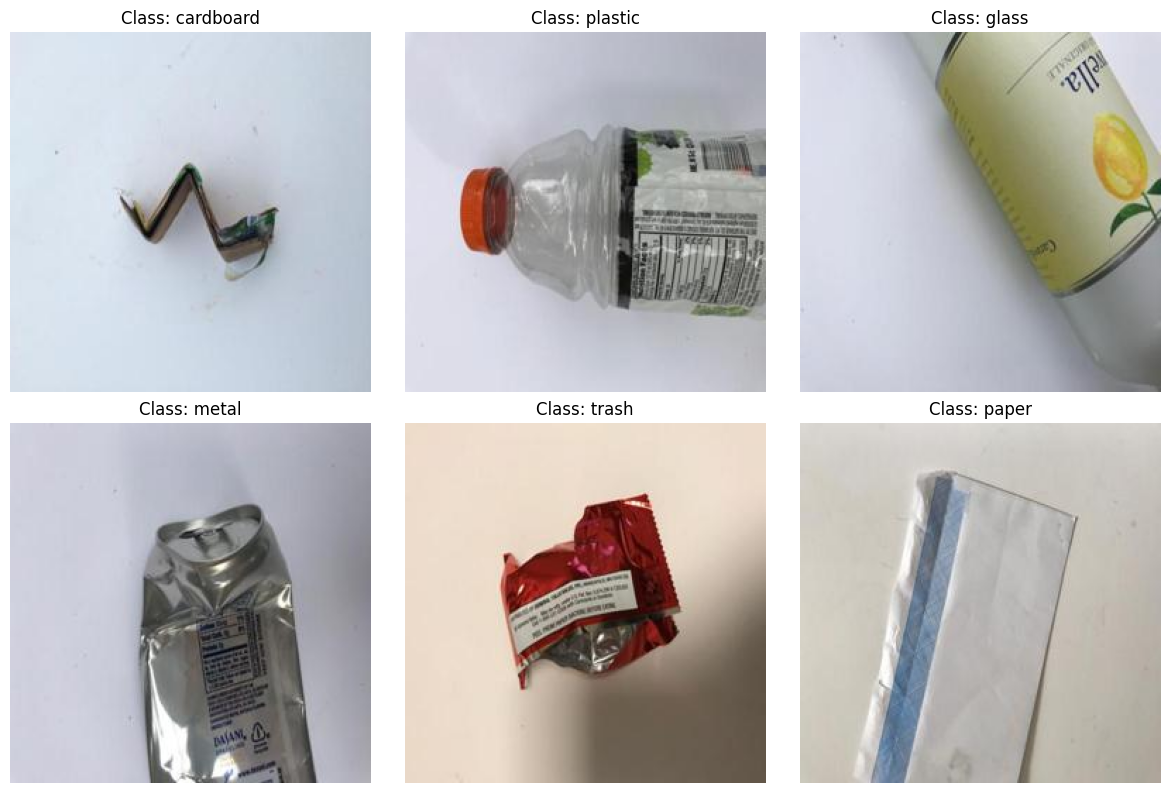

In [6]:
filename=["cardboard_02038.jpg","plastic_00121.jpg","glass_00055.jpg",
         "metal_00005.jpg","trash_00040.jpg","paper_00004.jpg"]
image_plot=PLOT_IMAGE(filename,train_df.label.unique().tolist())
image_plot.plt()

In [7]:
train_df.shape

(13901, 2)

## **Creating class to clean data**

**1)Resize data to (224,224)**<br>
**2)Covert image to RGB**<br>
**3) Create new column in data as clean_image**

In [8]:
class CLEAN_DATA:
    def __init__(self,df:pd.DataFrame=None,
                image_convert:str="RGB",
                resize:tuple[int,int]=CONFIG.img_size,
                base_path:str=CONFIG.images)->None:
        self.df=df.copy()
        self.image_convert=image_convert
        self.resize=resize
        self.base_path=base_path
    def clean(self)->pd.DataFrame:
        clean_images=[]
        for _,row in self.df.iterrows():
            file_name=row.filename
            label=row.label

            img_path =os.path.join(self.base_path,
                                  label,file_name)
            image = Image.open(img_path)
            image=image.resize(self.resize)
            image=image.convert(self.image_convert)
            image=np.array(image)

            clean_images.append(image)
        self.df["clean_image"]=clean_images
        return self.df
    

**Storing clean data in clean_data variable**

In [9]:
clean_data=CLEAN_DATA(train_df).clean()

In [10]:
clean_data.head()

,filename,label,clean_image
0,cardboard_02038.jpg,cardboard,"[[[223, 227, 239], [223, 227, 239], [223, 227,..."
1,cardboard_02320.jpg,cardboard,"[[[122, 79, 44], [126, 83, 48], [128, 85, 50],..."
2,cardboard_01728.jpg,cardboard,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
3,cardboard_00093.jpg,cardboard,"[[[238, 215, 184], [239, 216, 185], [239, 216,..."
4,cardboard_00094.jpg,cardboard,"[[[255, 207, 144], [255, 210, 147], [253, 204,..."


In [11]:
clean_data.shape

(13901, 3)

## **Plotting random image (i,e 6) of every lable after cleaning data**

In [12]:
def plot_clean_images(df, n_per_class=1, rows=2, cols=3):
    labels = df["label"].unique()
    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    axes = axes.flatten()

    for i, label in enumerate(labels[:rows*cols]):
        # pick first (or random) clean image for this label
        sample = df[df["label"] == label].sample(n_per_class, random_state=42)
        img = sample["clean_image"].values[0]

        axes[i].imshow(img)
        axes[i].set_title(f"Class: {label}")
        axes[i].axis("off")

    # hide unused axes
    for j in range(i+1, rows*cols):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


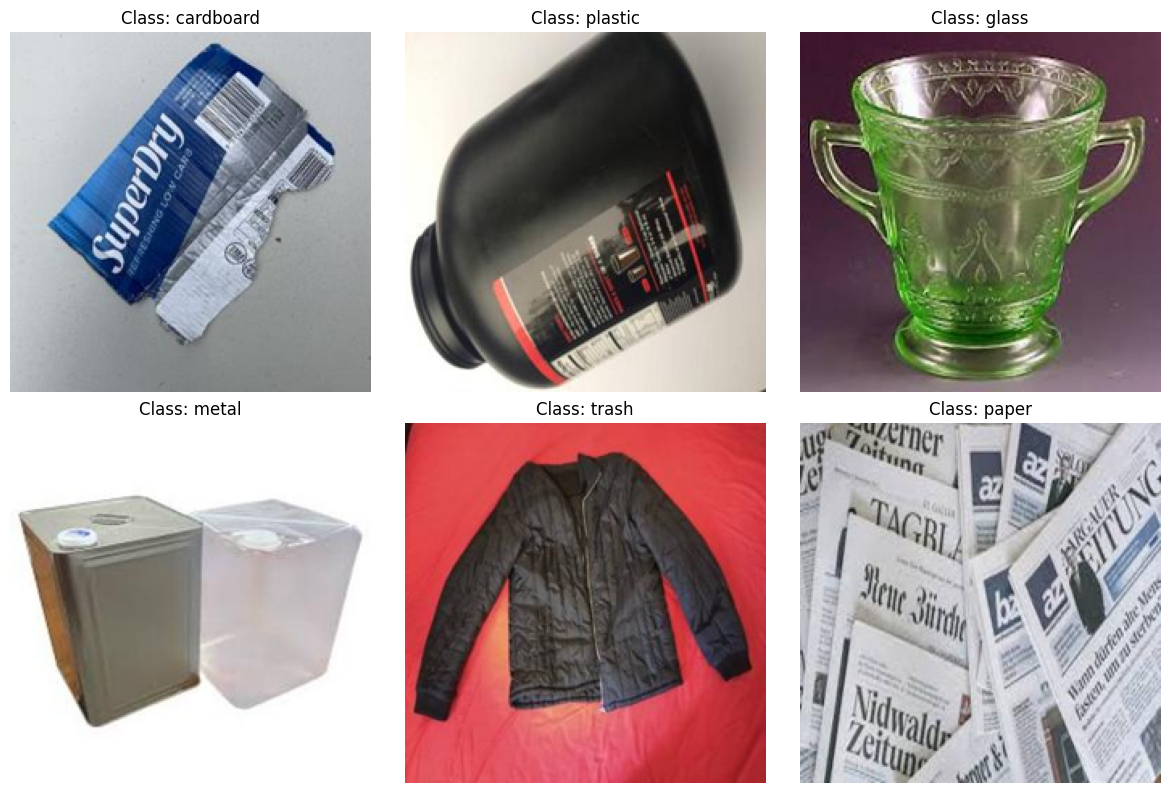

In [13]:
plot_clean_images(clean_data)

## **Splitting data as x and y for training model**

In [14]:
x = np.stack(clean_data["clean_image"].values)
y=clean_data.label

In [15]:
encode=LabelEncoder()
y_encode=encode.fit_transform(y)
print(f"Before y :{y}")
print(f"After y_encode :{y_encode}")

Before y :0        cardboard
1        cardboard
2        cardboard
3        cardboard
4        cardboard
           ...    
13896        paper
13897        paper
13898        paper
13899        paper
13900        paper
Name: label, Length: 13901, dtype: object
After y_encode :[0 0 0 ... 3 3 3]


In [16]:
x_train,x_test,y_train,y_test=train_test_split(x,y_encode,stratify=y_encode,
                                              test_size=0.2,random_state=42)

In [17]:
x_train.shape

(11120, 224, 224, 3)

In [18]:
x_test.shape

(2781, 224, 224, 3)

## **Creating class  to train model**

**1)Building modelding  and giving  summary ,usiing base model MobileNetV2**<br>
**2) compiling and fiting data and making use of callbacks containing:**<br>
    * a)EarlyStopping(to reduce overfitting)<br>
    * b)ReduceLROnPlateau (reduces learning rate when model is not improving)<br>
    * c)ModelCheckpoint (save best model automatically)<br>
**3)Also created process data to augument data**

In [23]:
class TrainModel:
    def __init__(self, summary: bool = False, fit_model: bool = True,
                 train_gen=None, val_gen=None):
        self.fit_model = fit_model
        self.train_gen = train_gen
        self.val_gen = val_gen
        self.summary = summary
        self.model = None

    def build_model(self):
        print("BUILDING MODEL STARTED...\n")
        base_model = MobileNetV2(
            weights='imagenet',
            include_top=False,
            input_shape=(*CONFIG.img_size, 3),
            alpha=1.0
        )
        base_model.trainable = True

        self.model = keras.Sequential([
            base_model,
            keras.layers.GlobalAveragePooling2D(),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(512, activation='relu'),
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.4),
            keras.layers.Dense(256, activation='relu'),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(CONFIG.num_class, activation='softmax')
        ])

        if self.summary:
            print("SUMMARY OF MODEL CREATED..\n")
            self.model.summary()

        return self.model

    def compile_and_fit(self, callbacks=None):
        callbacks = [
                keras.callbacks.EarlyStopping(
                    monitor="val_loss", 
                    patience=5, 
                    restore_best_weights=True,
                    verbose=1
                ),
                keras.callbacks.ReduceLROnPlateau(
                    monitor="val_loss", 
                    factor=0.2, 
                    patience=3,
                    min_lr=1e-7,
                    verbose=1
                ),
                keras.callbacks.ModelCheckpoint(
                    "best_model.h5",
                    monitor="val_accuracy",
                    save_best_only=True,
                    verbose=1
                )
]
        if self.model is None:
            self.build_model()
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss=CONFIG.loss,
            metrics=["accuracy"]
        )
        history = None
        if self.fit_model:
            history = self.model.fit(
                self.train_gen,
                epochs=50,
                batch_size=CONFIG.batch_size,
                validation_data=self.val_gen,
                callbacks=callbacks,
                verbose=1
            )
        return history

class ProcessData:
    def __init__(self, x_train, y_train, x_test, y_test, use_image_gen: bool = True):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.use_image_gen = use_image_gen

    def mobilenet_preprocess(self, x):
        """Preprocess images for MobileNetV2"""
        x = x.astype('float32')
        return x

    def image_generate(self):
        try:
            if self.use_image_gen:
                print("GENERATING IMAGE DATA...\n")
                datagen = ImageDataGenerator(
                    preprocessing_function=self.mobilenet_preprocess,
                    rotation_range=45,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    zoom_range=0.4,
                    shear_range=0.15,
                    horizontal_flip=True,
                    brightness_range=[0.8, 1.2],
                    fill_mode="nearest",
                    validation_split=0.2
                )

                train_gen = datagen.flow(
                    self.x_train, self.y_train,
                    batch_size=CONFIG.batch_size,
                    shuffle=True,
                    seed=CONFIG.seed,
                    subset='training'
                )

                val_gen = ImageDataGenerator(preprocessing_function=self.mobilenet_preprocess,
                                            validation_split=0.2).flow(
                    self.x_train, self.y_train,
                    batch_size=CONFIG.batch_size,
                    shuffle=False,
                    seed=CONFIG.seed,
                    subset='validation'
                )
                print("GENEATING DONE :)")
                return train_gen, val_gen
            else:
                print("No image data generated.")
        except Exception as e:
            print("Error in image generation:", e)


In [24]:
train_gen, val_gen=ProcessData( x_train, y_train, x_test, y_test).image_generate()

GENERATING IMAGE DATA...

GENEATING DONE :)


## **Storing model accuracy, val accuracy ,loss and val_loss in history**

**1)And showing model summary i.e the summary of cnn model architechure**<br>
**2)Running epoch to 50 but stops in epochs in 35 with best weight and baise in epoch in 30 and storing model as best_model.h5**<br>
**3) epoch=30 : accuracy: 0.9671 - loss: 0.1014 - val_accuracy: 0.9474 - val_loss: 0.1833 - learning_rate: 8.0000e-06**

In [25]:
model=TrainModel(train_gen=train_gen,val_gen=val_gen,summary=True)
model.build_model()
history=model.compile_and_fit()

BUILDING MODEL STARTED...



I0000 00:00:1757250557.076595     285 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757250557.077315     285 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


SUMMARY OF MODEL CREATED..



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,080,902 (11.75 MB)

 Trainable params: 3,045,766 (11.62 MB)

 Non-trainable params: 35,136 (137.25 KB)

Epoch 1/50


I0000 00:00:1757250598.335458     325 service.cc:148] XLA service 0x7a4f58005350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757250598.336393     325 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757250598.336422     325 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757250601.864670     325 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1757250622.921435     325 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.3883 - loss: 1.6604
Epoch 1: val_accuracy improved from -inf to 0.39164, saving model to best_model.h5
278/278 ━━━━━━━━━━━━━━━━━━━━ 174s 403ms/step - accuracy: 0.3887 - loss: 1.6593 - val_accuracy: 0.3916 - val_loss: 2.3417 - learning_rate: 0.0010
Epoch 2/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.6636 - loss: 0.9544
Epoch 2: val_accuracy improved from 0.39164 to 0.44514, saving model to best_model.h5
278/278 ━━━━━━━━━━━━━━━━━━━━ 106s 382ms/step - accuracy: 0.6637 - loss: 0.9542 - val_accuracy: 0.4451 - val_loss: 2.6260 - learning_rate: 0.0010
Epoch 3/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.7342 - loss: 0.7853
Epoch 3: val_accuracy improved from 0.44514 to 0.50090, saving model to best_model.h5
278/278 ━━━━━━━━━━━━━━━━━━━━ 107s 384ms/step - accuracy: 0.7342 - loss: 0.7852 - val_accuracy: 0.5009 - val_loss: 3.0177 - learning_rate: 0.0010
Epoch 4/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - a

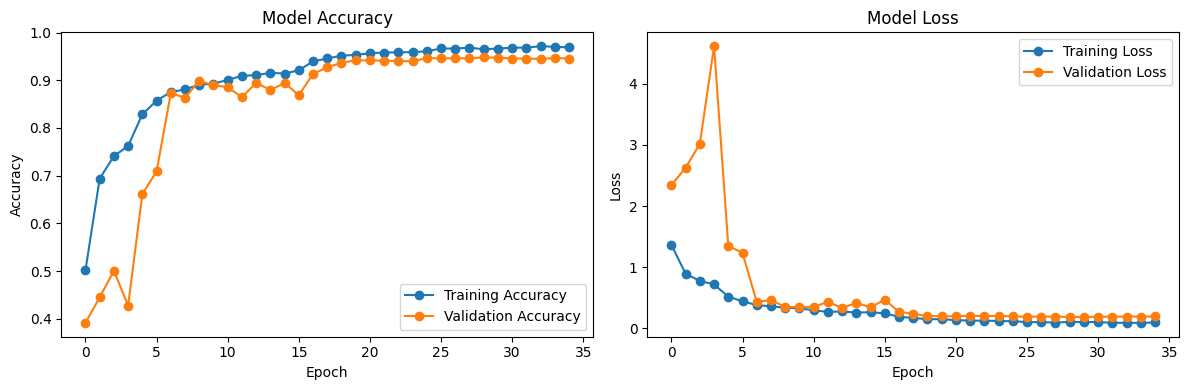

Test accuracy: 0.9435
Test loss: 0.2049
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.93      0.98      0.96       443
       glass       0.96      0.92      0.94       500
       metal       0.90      0.95      0.93       417
       paper       0.97      0.95      0.96       463
     plastic       0.94      0.92      0.93       458
       trash       0.96      0.94      0.95       500

    accuracy                           0.94      2781
   macro avg       0.94      0.94      0.94      2781
weighted avg       0.94      0.94      0.94      2781


Confusion Matrix:


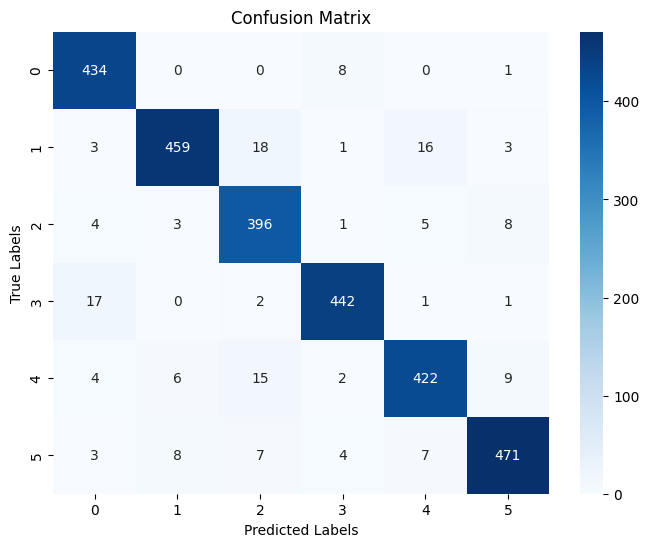

In [34]:
def plot_history(history):  
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy',marker="o")
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy',marker="o")
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss',marker="o")
    ax2.plot(history.history['val_loss'], label='Validation Loss',marker="o")
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)

# Evaluate the model
test_loss, test_acc = model.model.evaluate(x_test, y_test, verbose=0)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

# Generate predictions
y_pred_probs = model.model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=encode.classes_))

# Confusion matrix
print("\nConfusion Matrix:")
cm=confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()